# Computationnal Statistics - TP 3
*BLANCHARD Théau*

# Exercise 1

## Question 1

For the sake of simplicity we will suppose that $v_\xi = v_\tau = v$ and that $m_\xi = m_\tau = m$. Also we suppose that the number of observations is the the same for all patients and is egal to $K$. Additionnaly the log likelihood are all writen up to a constant term.

Using Bayes rule we can write :
$$
\log q(y,z,\theta) = \log q(y | z,\theta) + \log q(z_{pop} | \theta) + \sum_{i=1}^n \log q(z_i | \theta) + \log q(\theta)
$$

Where :

$$
 \log q(y | z,\theta) = -nK \log(\sigma) - \frac{1}{2\sigma^2} \sum_{i=1}^n \sum_{j=1}^K (y_{ij} - d(t_{i,j}))^2
$$

$$
\log q(z_{pop} | \theta) = -\frac{1}{2} \left[ \frac{(t_0 - \bar{t_0})^2}{\sigma_{t_0}^2} + \frac{(v_0 - \bar{v_0})^2}{\sigma_{v_0}^2} \right]
$$

$$
\sum_{i=1}^n \log q(z_i | \theta) = -n\log(\sigma_{\tau}) - n\log(\sigma_{\xi})  - \frac{1}{2} \sum_{i=1}^n \frac{\tau_i^2}{\sigma_{\tau}^2} - \frac{1}{2} \sum_{i=1}^n \frac{\xi_i^2}{\sigma_{\xi}^2}
$$

And

$$
\log q(\theta) = -\frac{1}{2} \frac{(\bar{t_0}-\bar{\bar{t_0}})}{s_{t_0}^2}  -\frac{1}{2} \frac{(\bar{v_0}-\bar{\bar{v_0}})}{s_{v_0}^2} - (m+2) \left( \log \sigma_\xi+ \log \sigma_\tau + \log \sigma \right) - \frac{v^2}{2} \left( \frac{1}{\sigma_\xi^2} + \frac{1}{\sigma_\tau^2} + \frac{1}{\sigma^2} \right)
$$

## Question 2

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invwishart, uniform,rayleigh

from IPython.display import clear_output
from time import time

np.random.seed(1312) # set seed with for reproducibility

In [32]:
# Fixed parameters
sigma_p0 = sigma_t0 = sigma_v0 = 0.1
p0_bar = 1
p0 = norm(loc=p0_bar, scale=sigma_p0).rvs()

t0_barbar = v0_barbar = 1
s_t0 = s_v0 = 0.1
v,m = 3,4

In [33]:
# Sample parameters
t0_bar_true = norm.rvs(loc=t0_barbar, scale=s_t0)
v0_bar_true = norm.rvs(loc=v0_barbar, scale=s_v0)
sigma_xi_true = np.sqrt(invwishart.rvs(v, scale=m))
sigma_tau_true = np.sqrt(invwishart.rvs(v, scale=m))
sigma_true = np.sqrt(invwishart.rvs(v, scale=m))

theta_true = np.array([t0_bar_true, v0_bar_true, sigma_xi_true, sigma_tau_true, sigma_true])

print("True parameters: ")
print(f"{t0_bar_true = }")
print(f"{v0_bar_true = }")
print(f"{sigma_xi_true = }")
print(f"{sigma_tau_true = }")
print(f"{sigma_true = }")

True parameters: 
t0_bar_true = 0.9857646451806431
v0_bar_true = 1.1658246827418346
sigma_xi_true = 1.2529471997369164
sigma_tau_true = 1.8327302006534134
sigma_true = 1.1701517987193117


In [34]:
# Sample fixed effetcs
t0_true = norm.rvs(loc=t0_bar_true, scale=sigma_t0)
v0_true = norm.rvs(loc=v0_bar_true, scale=sigma_v0)

z_pop_true = np.array([t0_true, v0_true])

In [35]:
# Sample random effects
N, K = 50, 20

xi_true = norm.rvs(loc=0, scale=sigma_xi_true, size=N)
tau_true = norm.rvs(loc=0, scale=sigma_tau_true, size=N)
alphas_true = np.exp(xi_true)

z_i_true = np.array([xi_true, tau_true]).flatten()

In [36]:
z_true = np.concatenate((z_pop_true,xi_true,tau_true))

In [37]:
# Sample data
def d(t,v0=v0_true,t0=t0_true):
    return p0 + v0 * (t-t0)

def d_i(alphas,t,tau,t0,v0):
    return d(alphas*(t-t0-tau)+t0,t0=t0,v0=v0)

t = np.arange(K)
epsilon = norm.rvs(loc=0, scale=sigma_true, size=(N,K))
y = d_i(alphas_true[:,None],t,tau_true[:,None],t0_true,v0_true) + epsilon

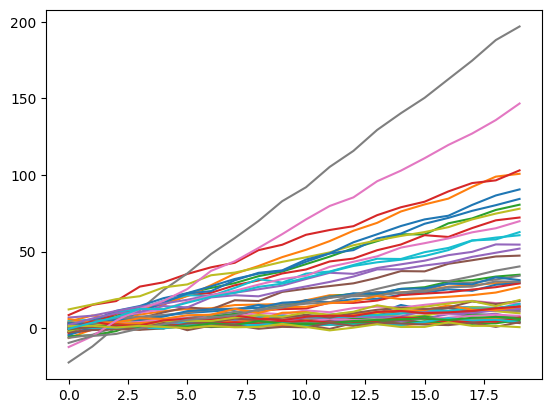

In [38]:
plt.plot(y.T)
plt.show()

In [39]:
def S_fun(y,z):
    '''Computes the sufficient statistics of the data y given the latent variables z'''
    t0 = z[0]
    v0 = z[1]
    xi = z[2:2+N]
    tau = z[2+N:]
    alphas = np.exp(xi)

    d = d_i(alphas[:,None],t,tau[:,None],t0,v0)
    S1 = np.mean((y-d)**2)
    S2 = np.mean(xi**2)
    S3 = np.mean(tau**2)
    S4 = t0
    S5 = v0
    S6 = -1/(2*sigma_t0**2)*t0**2
    S7 = -1/(2*sigma_v0**2)*v0**2

    return np.array([S1,S2,S3,S4,S5,S6,S7])

def Phi_fun(theta,K,N):

    t0_bar, v0_bar, sigma_xi, sigma_tau, sigma = theta

    phi1 = - K*N/(2*sigma**2)
    phi2 = - N/(2*sigma_xi**2)
    phi3 = - N/(2*sigma_tau**2)
    phi4 = t0_bar/sigma_t0**2
    phi5 = v0_bar/sigma_v0**2
    phi6 = 1
    phi7 = 1

    return np.array([phi1,phi2,phi3,phi4,phi5,phi6,phi7])

def log_probability(theta,y,z,K,N):
    """Computes the log probability of the model """
    S = S_fun(y,z)
    Phi = Phi_fun(theta,K,N)
    return np.dot(S,Phi)

## Question 3

We have that $q(z|\theta,y) = \frac{q(z,\theta,y)}{q(\theta,y)}$. Hence when computing the acceptance ratio, the term $q(\theta,y)$ cancels out and we're left with the ratio of the likelihoods of the two proposals. For computationnal purposes, we will use the log likelihoods which leads to compute the difference between the two log likelihoods. Additionnaly because the term $\psi(\theta)$ is constant, we can use only the term $\langle S(y,s);\phi(\theta) \rangle$.

In [40]:
def HM_sampler(z0,pi_fun,sigma_prop,maxiter=1000,verbose=False):
    ''' 
    Hastings-Metropolis sampler

    Parameters
    ----------
    z0 : array of shape (b,), initial value of the Markov chain (here b = 2+2N)
    pi_fun : function, log density
    sigma_prop : float, standard deviation of the proposal distribution
    maxiter : int, number of iterations
    verbose : bool, print acceptance rate

    Returns
    -------
    z_list : list of arrays, accepted values of the Markov chain
    '''

    #Initialisation
    z = z0

    z_list = [z0]

    #Loop
    for i in range(maxiter):
        #Proposal
        z_prop = z + norm.rvs(loc=0, scale=sigma_prop, size=z.shape)

        #Acceptance probability
        log_ratio = min(0,pi_fun(z_prop) - pi_fun(z))

        #Acceptance
        if np.log(np.random.rand()) < log_ratio:
            z = z_prop

            z_list.append(z)

    if verbose:
        print("Acceptance rate: ", len(z_list)/maxiter)
    
    if len(z_list) == 1:
        print("Warning : no point accepted, decrease sigma_prop")

    return z_list

In [41]:
#Given that the parameters are fixed, we can use only the dot product to evaluate the ratio
pi_fun = lambda z: np.dot(S_fun(y,z),Phi_fun(theta_true,K,N))
z_list = HM_sampler(z_true,pi_fun,sigma_prop=2E-3,maxiter=5000,verbose=True)

Acceptance rate:  0.3086


# Question 4

Given that
$$
\log q(y,z,\theta) = \psi(\theta)  +  \langle S(y,z) ; \phi(\theta) \rangle 
$$ 
We get that using the log concavity of the likelihood function, the maximum for $\theta$ is given by the solution of the following equation:
$$
\nabla_\theta \log q(y,z,\theta) = \nabla_\theta \phi(\theta) + \sum_{k=1} S_k \nabla_\theta \psi_k(\theta) = 0
$$

We thus get the following results :
- $\bar{t_0}^{(k+1)} = \left( \frac{S_4}{\sigma_{t_0}^2} + \frac{\bar{\bar{t_0}}}{s_{t_0}^2}  \right) \left( \frac{1}{\sigma_{t_0}^2} + \frac{1}{s_{t_0}^2}  \right)^{-1}  $
- $\bar{v_0}^{(k+1)} = \left( \frac{S_5}{\sigma_{v_0}^2} + \frac{\bar{\bar{v_0}}}{s_{v_0}^2}  \right) \left( \frac{1}{\sigma_{v_0}^2} + \frac{1}{s_{v_0}^2}  \right)^{-1}  $
- ${\sigma}^{(k+1)} = \sqrt{ \frac{S_1 Kn+v^2}{nK+m+2} }$
- ${\sigma_\xi}^{(k+1)} = \sqrt{ \frac{S_2n+v_\xi^2}{n+m_\xi+2} }$
- ${\sigma_\tau}^{(k+1)} = \sqrt{ \frac{S_3n+v_\tau^2}{n+m_\tau+2} }$



In [42]:
def M_step(S_k):
    '''Maximization step of the SAEM algorithm
    
    Parameters
    ----------
    S_k : array of shape (7,), sufficient statistics of the data y given the latent variables z_k
    
    Returns
    -------
    theta : array of shape (5,), updated parameters of the model
    '''

    t0_bar = (S_k[3]/sigma_t0**2 + t0_barbar/s_t0**2)/(1/sigma_t0**2 + 1/s_t0**2)
    v0_bar = (S_k[4]/sigma_v0**2 + v0_barbar/s_v0**2)/(1/sigma_v0**2 + 1/s_v0**2)
    sigma_xi = np.sqrt((S_k[1]*N+v**2)/(N+m+2))
    sigma_tau = np.sqrt((S_k[2]*N+v**2)/(N+m+2))
    sigma = np.sqrt((S_k[0]*K*N+v**2)/(N*K+m+2))

    theta_max = np.array([t0_bar, v0_bar, sigma_xi, sigma_tau, sigma])

    return theta_max


In [43]:
def MCMC_SAEM(y,pi_fun,theta_0,z_0,maxiter,maxiter_HM,sigma_prop,verbose=False):
    '''
    MCMC-SAEM algorithm using the Hastings-Metropolis random walk sampler

    Parameters
    ----------
    y : array of shape (K,N), data
    pi_fun : function, log density parametrized by theta and z such as pi_fun(z,theta)
    theta_0 : array of shape (5,), initial value of the parameters
    z_0 : array of shape (b,), initial value of the latent variables
    maxiter : int, number of iterations
    maxiter_HM : int, number of iterations of the Hastings-Metropolis sampler
    sigma_prop : float, standard deviation of the proposal distribution
    verbose : bool, print acceptance rate

    Returns
    -------
    theta_list : list of arrays, accepted values of the parameters
    log_list : list of floats, log density at each iteration
    '''
    
    # Initialisation
    K,N = y.shape
    theta_k = theta_0
    z_k = z_0

    S_k = np.zeros(7)

    #Step_size
    Nb = maxiter//2
    alpha_burning = 0.75
    epsilon = np.array([1 if i <= Nb else 1/(i-Nb)**alpha_burning for i in range(maxiter)])

    #Login metrics
    theta_list = [theta_k]
    log_k = log_probability(theta_k,y,z_k,K,N)
    log_list = []

    #Loop
    for k in range(maxiter):
        # Simulation
        target_distrib = lambda z: pi_fun(z,theta_k)
        z_k = HM_sampler(z_k,target_distrib,sigma_prop,maxiter=maxiter_HM,verbose=verbose)[-1]

        # Stochastic approximation
        S_k += epsilon[k] * (S_fun(y,z_k) - S_k)

        # Maximization
        theta_k = M_step(S_k)

        # Log
        theta_list.append(theta_k)
        log_k = log_probability(theta_k,y,z_k,K,N)
        log_list.append(log_k)

        if k%100 == 0:
            clear_output(wait=True)
            print("Iteration: ", k, ",Log probability: ", log_k)
            HM_sampler(z_k,target_distrib,sigma_prop,maxiter=maxiter_HM,verbose=True)[-1]
            plt.plot(log_list)
            plt.show()

    return np.array(theta_list), log_list



In [44]:
true_log = log_probability(theta_true,y,z_true,K,N)
print("True log probability: ", true_log)

True log probability:  -418.32533098428456


Iteration:  10000 ,Log probability:  -439.21097768441814
Acceptance rate:  0.31


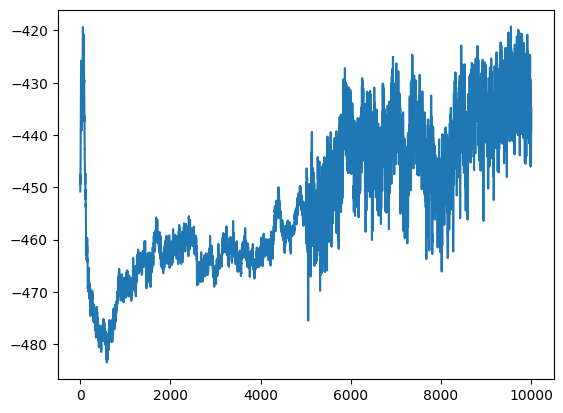

Elapsed time:  313.98701429367065


In [45]:
pi_fun = lambda z,theta: np.dot(S_fun(y,z),Phi_fun(theta,K,N))

theta_0 = np.random.random(theta_true.size) #0.2*np.ones_like(theta_true)
z_0 = np.random.random(z_true.size)


st = time()
theta_list, log_list = MCMC_SAEM(y,pi_fun,theta_0,z_0,maxiter=10001,maxiter_HM=200,sigma_prop=2E-3,verbose=False)
print("Elapsed time: ", time()-st)

In [46]:
t0_bar_est = theta_list[1:,0]
v0_bar_est = theta_list[1:,1]
sigma_xi_est = theta_list[1:,2]
sigma_tau_est = theta_list[1:,3]
sigma_est = theta_list[1:,4]

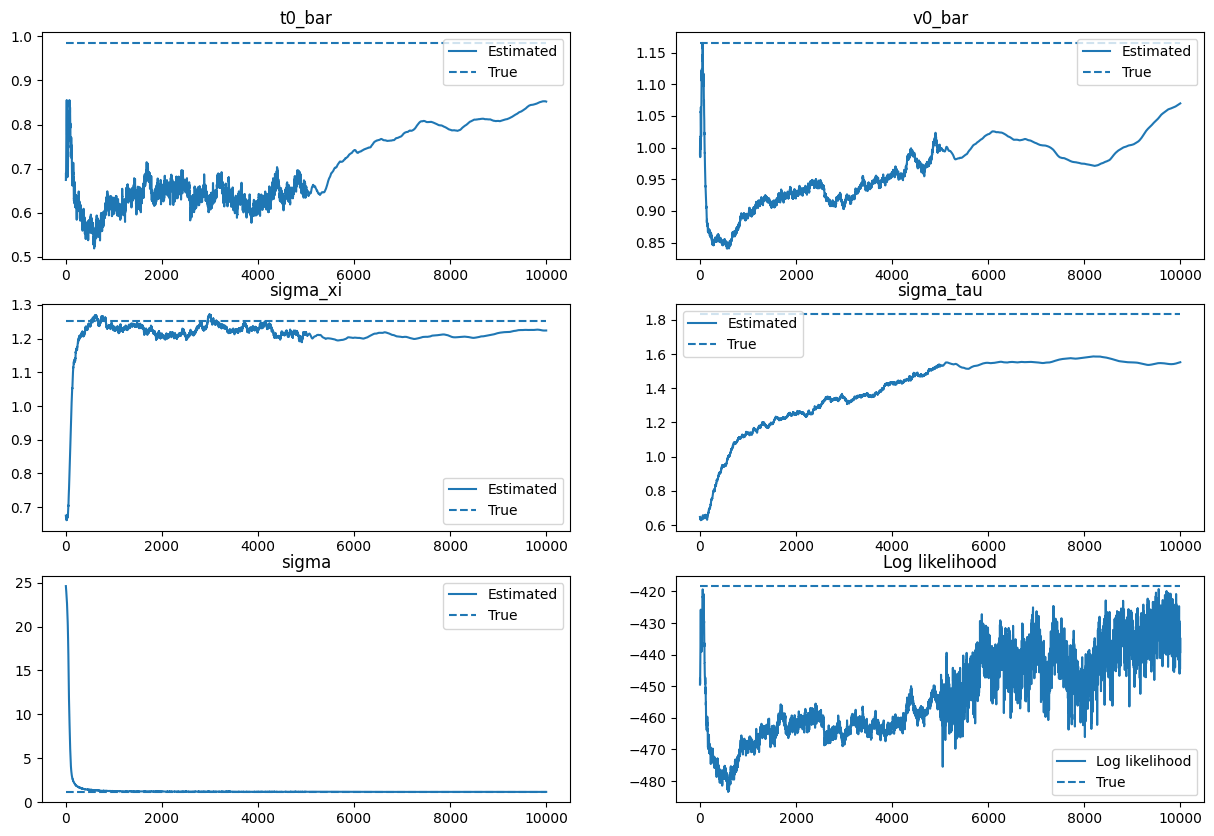

In [47]:
show_true = True

fig,axes = plt.subplots(3,2,figsize=(15,10))

axes[0,0].plot(t0_bar_est,label="Estimated")
axes[0,0].set_title("t0_bar")

axes[0,1].plot(v0_bar_est,label="Estimated")
axes[0,1].set_title("v0_bar")

axes[1,0].plot(sigma_xi_est,label="Estimated")
axes[1,0].set_title("sigma_xi")

axes[1,1].plot(sigma_tau_est,label="Estimated")
axes[1,1].set_title("sigma_tau")

axes[2,0].plot(sigma_est,label="Estimated")
axes[2,0].set_title("sigma")

axes[2,1].plot(log_list[1:],label="Log likelihood")
axes[2,1].set_title("Log likelihood")


if show_true :
    axes[0,0].hlines(theta_true[0],0,len(t0_bar_est),linestyles='dashed',label="True")
    axes[0,1].hlines(theta_true[1],0,len(v0_bar_est),linestyles='dashed',label="True")
    axes[1,0].hlines(theta_true[2],0,len(sigma_xi_est),linestyles='dashed',label="True")
    axes[1,1].hlines(theta_true[3],0,len(sigma_tau_est),linestyles='dashed',label="True")
    axes[2,0].hlines(theta_true[4],0,len(sigma_est),linestyles='dashed',label="True")
    axes[2,1].hlines(true_log,0,len(log_list),linestyles='dashed',label="True")

for ax in axes.flatten():
    ax.legend()
plt.show()


## Question 5

We have that 
\begin{align}
q(z_i|z_{pop},\theta,y) 
&= \frac{q(z_i,z_{pop},\theta,y)}{q(z_{pop},\theta,y)} \\
&= \frac{ \prod_{j \neq i} (q(z_j,\theta,y))q(z_i,z_{pop},\theta,y)}{\prod_{j \neq i} (q(z_j,\theta))q(z_{pop},\theta,y)} \\
&= \frac{ q(z,\theta,y)}{\prod_{j \neq i} (q(z_j,\theta))q(z_{pop},\theta,y)} \\
\end{align}

So again we can use just the log likelihoods to compute the acceptance ratio because the denominator will cancel out.

In [48]:
def HMwG(z_k,pi_fun,sigma_prop,maxiter=1000,verbose=False):
    ''' 
    Hasting Metropolis random walk within Gibbs sampler

    Parameters
    ----------
    z_k : array of shape (b,), initial value of the latent variables to sample
    pi_fun : function, log density
    sigma_prop : float, standard deviation of the proposal distribution
    maxiter : int, number of iterations
    verbose : bool, print acceptance rate

    Returns
    -------
    z_list : list of arrays, accepted values of the latent variables
    '''

    for l in range(len(z_k)):
        z_k_prop = np.copy(z_k)

        accept = 0
        for k in range(maxiter):
            z_k_prop[l] = np.random.normal(z_k_prop[l],sigma_prop)
            log_ratio = pi_fun(z_k_prop) - pi_fun(z_k)
            if np.log(np.random.random()) < log_ratio:
                z_k[l] = z_k_prop[l]
                accept += 1
            
        if verbose:
            print("Acceptance rate for z[",l,"]: ", accept/maxiter)
        if accept==0 : 
            print("Warning: no point accepted for z[",l,"], decrease sigma_prop")
    return z_k        
    

In [49]:
def pi_fun_z(z_i,z_pop,theta=theta_true):
    '''Given a value of z_i an z_pop, concatenate them and compute the log probability'''
    z = np.concatenate((z_pop,z_i))
    return log_probability(theta,y,z,K,N)


z_i_0 = np.random.random(z_i_true.size)

z_i_sampled = HMwG(z_i_0,lambda z_i: pi_fun_z(z_i,z_pop=z_pop_true),sigma_prop=2E-3,maxiter=1000,verbose=True)


Acceptance rate for z[ 0 ]:  0.033
Acceptance rate for z[ 1 ]:  0.116
Acceptance rate for z[ 2 ]:  0.035
Acceptance rate for z[ 3 ]:  0.06
Acceptance rate for z[ 4 ]:  0.025
Acceptance rate for z[ 5 ]:  0.067
Acceptance rate for z[ 6 ]:  0.028
Acceptance rate for z[ 7 ]:  0.013
Acceptance rate for z[ 8 ]:  0.047
Acceptance rate for z[ 9 ]:  0.08
Acceptance rate for z[ 10 ]:  0.868
Acceptance rate for z[ 11 ]:  0.047
Acceptance rate for z[ 12 ]:  0.03
Acceptance rate for z[ 13 ]:  0.067
Acceptance rate for z[ 14 ]:  0.01
Acceptance rate for z[ 15 ]:  0.0
Acceptance rate for z[ 16 ]:  0.028
Acceptance rate for z[ 17 ]:  0.043
Acceptance rate for z[ 18 ]:  0.146
Acceptance rate for z[ 19 ]:  0.033
Acceptance rate for z[ 20 ]:  0.011
Acceptance rate for z[ 21 ]:  0.006
Acceptance rate for z[ 22 ]:  0.098
Acceptance rate for z[ 23 ]:  0.07
Acceptance rate for z[ 24 ]:  0.114
Acceptance rate for z[ 25 ]:  0.0
Acceptance rate for z[ 26 ]:  0.132
Acceptance rate for z[ 27 ]:  0.807
Acceptance 

We can see that we should preferably use a different $\sigma_{prop}$ for the $\xi_i$ and the $\tau_i$ because the acceptance ratio is much higher for the $\xi_i$ than for the $\tau_i$.

## Question 6

We have that 
\begin{align}
q(z_{pop}|z_i,\theta,y) 
&= \frac{q(z_i,z_{pop},\theta,y)}{q(z_i,\theta,y)} \\
&= \frac{ \prod_{j \neq i} (q(z_j,\theta,y))q(z_i,z_{pop},\theta,y)}{\prod_{j \neq i} (q(z_j,\theta,y))q(z_i,\theta,y)} \\
&= \frac{ q(z,\theta,y)}{\prod_{j \neq i} (q(z_j,\theta,y))q(z_i,\theta,y)} \\
\end{align}

So again we can use just the log likelihoods to compute the acceptance ratio because the denominator will cancel out.

In [50]:
z_pop_0 = np.random.random(z_pop_true.size)

z_pop_sampled = HMwG(z_pop_0,lambda z_pop: pi_fun_z(z_i=z_i_true,z_pop=z_pop),sigma_prop=2E-4,maxiter=1000,verbose=True)

Acceptance rate for z[ 0 ]:  0.005
Acceptance rate for z[ 1 ]:  0.011


Again we should preferably use a different $\sigma_{prop}$ for the $t_0$ and the $v_0$ because the acceptance ratio is much higher for the $t_0$ than for the $v_0$.

## Question 7

In [51]:
def HMwG_SAEM(y,pi_fun,theta_0,z_0,maxiter,maxiter_HM,sigma_prop_zi,sigma_prop_zpop,verbose=False):
    '''
    Hasting Metropolis random walk within Gibbs sampler for the SAEM algorithm

    Parameters
    ----------
    y : array of shape (K,N), data
    pi_fun : function, log density parametrized by theta, z_i, z_pop such as pi_fun(z_i,z_pop,theta)
    theta_0 : array of shape (5,), initial value of the parameters
    z_0 : array of shape (b,), initial value of the latent variables (z_pop,z_i)
    maxiter : int, number of iterations
    maxiter_HM : int, number of iterations of the Hastings-Metropolis sampler
    sigma_prop_zi : float, standard deviation of the proposal distribution
    sigma_prop_zpop : float, standard deviation of the proposal distribution
    verbose : bool, print acceptance rate

    Returns
    -------
    theta_list : list of arrays, accepted values of the parameters
    log_list : list of floats, log density at each iteration
    '''
    
    # Initialisation
    K,N = y.shape
    theta_k = theta_0
    z_k = z_0

    S_k = np.zeros(7)

    #Step_size
    Nb = maxiter//2
    alpha_burning = 0.75
    epsilon = np.array([1 if i <= Nb else 1/(i-Nb)**alpha_burning for i in range(maxiter)])

    #Login metrics
    theta_list = [theta_k]
    log_k = log_probability(theta_k,y,z_k,K,N)
    log_list = []

    #Loop
    for k in range(maxiter):
        # Simulation
        target_distrib = lambda z_i,z_pop: pi_fun(z_i,z_pop,theta_k)
        
        
        z_k_i = z_k[2:]
        z_k_pop = z_k[:2]

        z_k_i = HMwG(z_k_i,lambda z_i : target_distrib(z_i,z_k_pop),sigma_prop_zi,maxiter=maxiter_HM,verbose=verbose)
        z_k_pop = HMwG(z_k_pop,lambda z_pop : target_distrib(z_k_i,z_pop),sigma_prop_zpop,maxiter=maxiter_HM,verbose=verbose)

        z_k = np.concatenate((z_k_pop,z_k_i))
        # Stochastic approximation
        S_k += epsilon[k] * (S_fun(y,z_k) - S_k)

        # Maximization
        theta_k = M_step(S_k)

        # Log
        theta_list.append(theta_k)
        log_k = log_probability(theta_k,y,z_k,K,N)
        log_list.append(log_k)

        if k%100 == 0:
            clear_output(wait=True)
            print("Iteration: ", k, "Log probability: ", log_k)
            plt.plot(log_list)
            plt.show()

    return np.array(theta_list), log_list



In [52]:
true_log = log_probability(theta_true,y,z_true,K,N)
print("True log probability: ", true_log)

True log probability:  -418.32533098428456


Iteration:  5000 Log probability:  -427.98588653967823


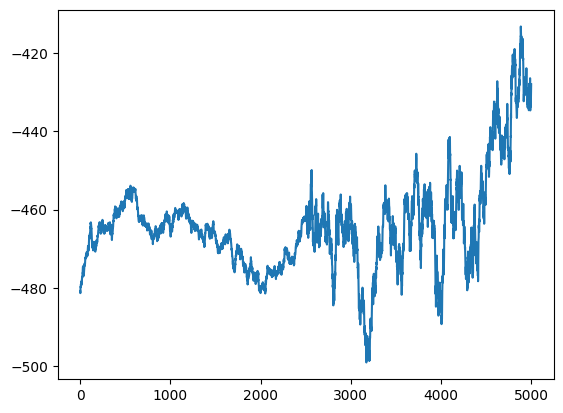

Elapsed time:  568.1971750259399


In [53]:
pi_fun = lambda z_i,z_pop,theta: pi_fun_z(z_i,z_pop,theta)

theta_0 = np.random.random(theta_true.size) #0.2*np.ones_like(theta_true)
z_0 = np.random.random(z_true.size)

st = time()
theta_list, log_list = HMwG_SAEM(y,pi_fun,theta_0,z_0,maxiter=5001,maxiter_HM=10,sigma_prop_zpop=2E-3,sigma_prop_zi=2E-3,verbose=False)
print("Elapsed time: ", time()-st)

In [54]:
t0_bar_est = theta_list[1:,0]
v0_bar_est = theta_list[1:,1]
sigma_xi_est = theta_list[1:,2]
sigma_tau_est = theta_list[1:,3]
sigma_est = theta_list[1:,4]

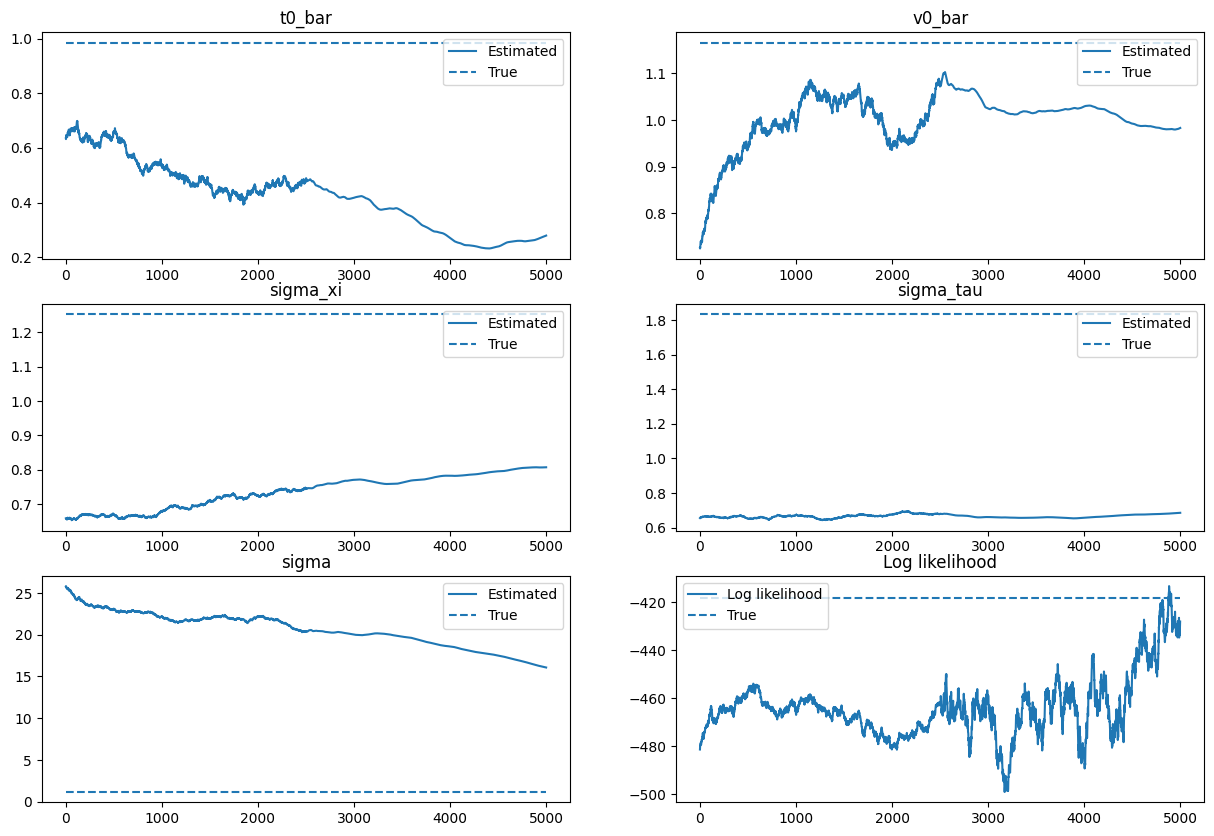

In [55]:
show_true = True

fig,axes = plt.subplots(3,2,figsize=(15,10))

axes[0,0].plot(t0_bar_est,label="Estimated")
axes[0,0].set_title("t0_bar")

axes[0,1].plot(v0_bar_est,label="Estimated")
axes[0,1].set_title("v0_bar")

axes[1,0].plot(sigma_xi_est,label="Estimated")
axes[1,0].set_title("sigma_xi")

axes[1,1].plot(sigma_tau_est,label="Estimated")
axes[1,1].set_title("sigma_tau")

axes[2,0].plot(sigma_est,label="Estimated")
axes[2,0].set_title("sigma")

axes[2,1].plot(log_list[1:],label="Log likelihood")
axes[2,1].set_title("Log likelihood")


if show_true :
    axes[0,0].hlines(theta_true[0],0,len(t0_bar_est),linestyles='dashed',label="True")
    axes[0,1].hlines(theta_true[1],0,len(v0_bar_est),linestyles='dashed',label="True")
    axes[1,0].hlines(theta_true[2],0,len(sigma_xi_est),linestyles='dashed',label="True")
    axes[1,1].hlines(theta_true[3],0,len(sigma_tau_est),linestyles='dashed',label="True")
    axes[2,0].hlines(theta_true[4],0,len(sigma_est),linestyles='dashed',label="True")
    axes[2,1].hlines(true_log,0,len(log_list),linestyles='dashed',label="True")

for ax in axes.flatten():
    ax.legend()
plt.show()

I didn't do enough iteration because it is too slow to converge.

## Question 8

The block Gibbs sampler is a good middle ground between the classic Hasting Metropolis sampler and the Hasting Metropolis within Gibbs sampler. It limits the number of iteration needed to sample a point because it sample only a block at a time instead of sampling each coordinate like in the HMwG. But it also limits the number of rejected proposals because it only samples one block at a time unlike the classic HM where the variables can be on a very different scale. This algorithm thus shine when the block are well chosen.

## Question 9

In [56]:
def HM_block_SAEM(y,pi_fun,theta_0,z_0,maxiter,maxiter_HM,sigma_prop_zi,sigma_prop_zpop,verbose=False):
    '''
    Hasting Metropolis random walk within Gibbs sampler for the SAEM algorithm

    Parameters
    ----------
    y : array of shape (K,N), data
    pi_fun : function, log density parametrized by theta, z_i, z_pop such as pi_fun(z_i,z_pop,theta)
    theta_0 : array of shape (5,), initial value of the parameters
    z_0 : array of shape (b,), initial value of the latent variables (z_pop,z_i)
    maxiter : int, number of iterations
    maxiter_HM : int, number of iterations of the Hastings-Metropolis sampler
    sigma_prop_zi : float, standard deviation of the proposal distribution
    sigma_prop_zpop : float, standard deviation of the proposal distribution
    verbose : bool, print acceptance rate

    Returns
    -------
    theta_list : list of arrays, accepted values of the parameters
    log_list : list of floats, log density at each iteration
    '''
    
    # Initialisation
    K,N = y.shape
    theta_k = theta_0
    z_k = z_0

    S_k = np.zeros(7)

    #Step_size
    Nb = maxiter//2
    alpha_burning = 0.75
    epsilon = np.array([1 if i <= Nb else 1/(i-Nb)**alpha_burning for i in range(maxiter)])

    #Login metrics
    theta_list = [theta_k]
    log_k = log_probability(theta_k,y,z_k,K,N)
    log_list = []

    #Loop
    for k in range(maxiter):
        # Simulation
        target_distrib = lambda z_i,z_pop: pi_fun(z_i,z_pop,theta_k)
        
        
        z_k_i = z_k[2:]
        z_k_prop = z_k[:2]

        z_k_i = HM_sampler(z_k_i,lambda z_i : target_distrib(z_i,z_k_prop),sigma_prop_zi,maxiter=maxiter_HM,verbose=verbose)[-1]
        z_k_prop = HM_sampler(z_k_prop,lambda z_pop : target_distrib(z_k_i,z_pop),sigma_prop_zpop,maxiter=maxiter_HM,verbose=verbose)[-1]

        z_k = np.concatenate((z_k_prop,z_k_i))
        # Stochastic approximation
        S_k += epsilon[k] * (S_fun(y,z_k) - S_k)

        # Maximization
        theta_k = M_step(S_k)

        # Log
        theta_list.append(theta_k)
        log_k = log_probability(theta_k,y,z_k,K,N)
        log_list.append(log_k)

        if k%100 == 0:
            clear_output(wait=True)
            print("Iteration: ", k, "Log probability: ", log_k)
            print("z_i | ",end='')
            HM_sampler(z_k_i,lambda z_i : target_distrib(z_i,z_k_prop),sigma_prop_zi,maxiter=maxiter_HM,verbose=True)
            print("z_pop | ",end='')
            HM_sampler(z_k_prop,lambda z_pop : target_distrib(z_k_i,z_pop),sigma_prop_zpop,maxiter=maxiter_HM,verbose=True)
            plt.plot(log_list)
            plt.show()

    return np.array(theta_list), log_list



In [57]:
true_log = log_probability(theta_true,y,z_true,K,N)
print("True log probability: ", true_log)

True log probability:  -418.32533098428456


Iteration:  5000 Log probability:  -458.92676104974134
z_i | Acceptance rate:  0.36
z_pop | Acceptance rate:  0.67


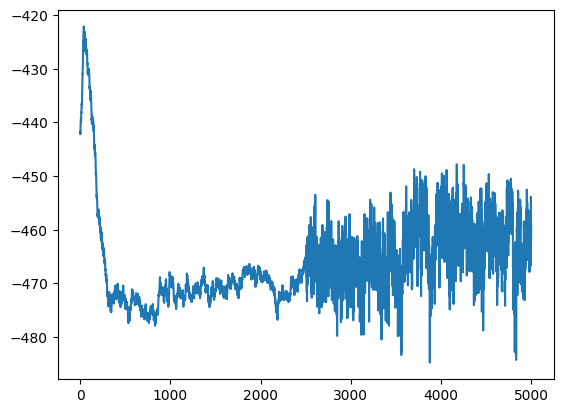

Elapsed time:  164.1725914478302


In [58]:
pi_fun = lambda z_i,z_pop,theta: pi_fun_z(z_i,z_pop,theta)

theta_0 = np.random.random(theta_true.size) #0.2*np.ones_like(theta_true)
z_0 = np.random.random(z_true.size)


st = time()
theta_list, log_list = HM_block_SAEM(y,pi_fun,theta_0,z_0,maxiter=5001,maxiter_HM=100,sigma_prop_zpop=1E-3,sigma_prop_zi=2E-3,verbose=False)
print("Elapsed time: ", time()-st)

In [59]:
t0_bar_est = theta_list[1:,0]
v0_bar_est = theta_list[1:,1]
sigma_xi_est = theta_list[1:,2]
sigma_tau_est = theta_list[1:,3]
sigma_est = theta_list[1:,4]

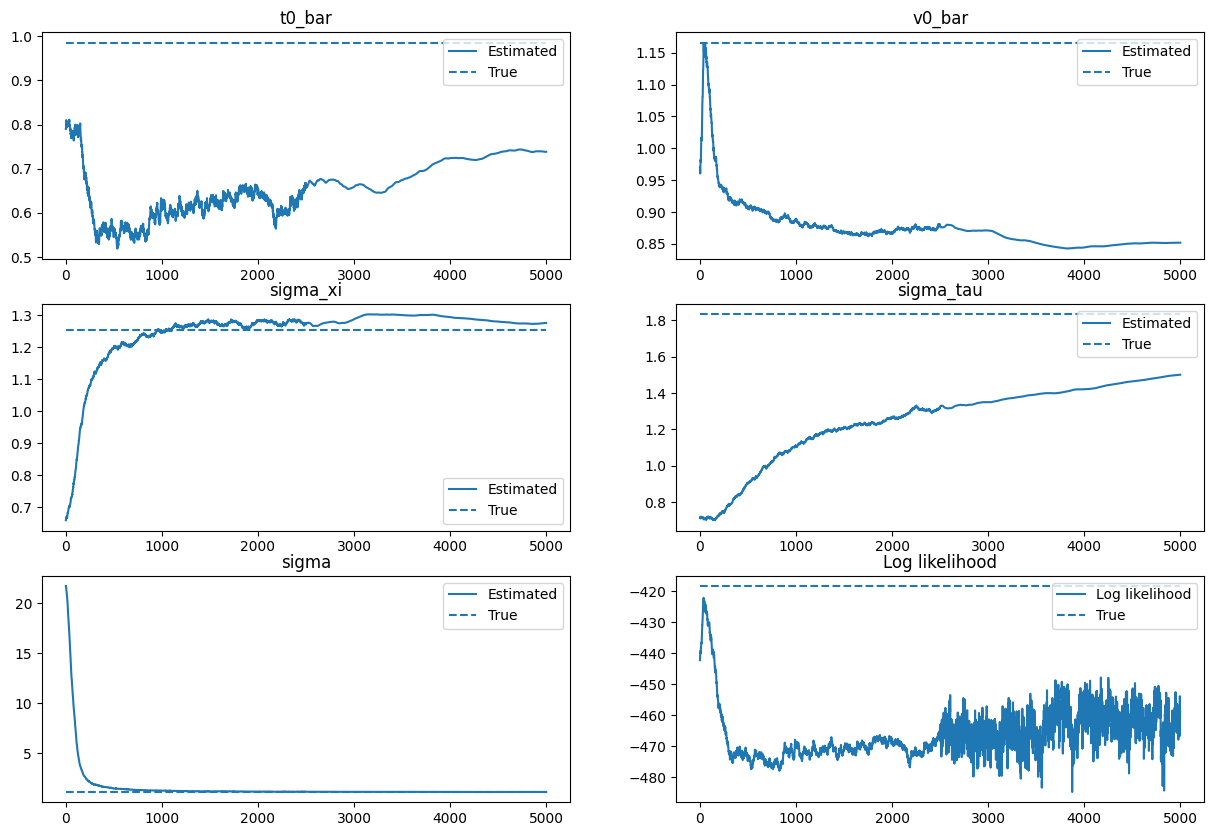

In [60]:
show_true = True

fig,axes = plt.subplots(3,2,figsize=(15,10))

axes[0,0].plot(t0_bar_est,label="Estimated")
axes[0,0].set_title("t0_bar")

axes[0,1].plot(v0_bar_est,label="Estimated")
axes[0,1].set_title("v0_bar")

axes[1,0].plot(sigma_xi_est,label="Estimated")
axes[1,0].set_title("sigma_xi")

axes[1,1].plot(sigma_tau_est,label="Estimated")
axes[1,1].set_title("sigma_tau")

axes[2,0].plot(sigma_est,label="Estimated")
axes[2,0].set_title("sigma")

axes[2,1].plot(log_list[1:],label="Log likelihood")
axes[2,1].set_title("Log likelihood")


if show_true :
    axes[0,0].hlines(theta_true[0],0,len(t0_bar_est),linestyles='dashed',label="True")
    axes[0,1].hlines(theta_true[1],0,len(v0_bar_est),linestyles='dashed',label="True")
    axes[1,0].hlines(theta_true[2],0,len(sigma_xi_est),linestyles='dashed',label="True")
    axes[1,1].hlines(theta_true[3],0,len(sigma_tau_est),linestyles='dashed',label="True")
    axes[2,0].hlines(theta_true[4],0,len(sigma_est),linestyles='dashed',label="True")
    axes[2,1].hlines(true_log,0,len(log_list),linestyles='dashed',label="True")

for ax in axes.flatten():
    ax.legend()
plt.show()

# Exercise 2

## Question 1

## Question 2

In `Dutta, S. (2012). Multiplicative random walk Metropolis-Hastings on the real line. Sankhya B, 74(2), 315-342` they found that the acceptance ratio that ensures the convergence of the algorithm is given by 
\begin{equation}
\alpha(y,x,\epsilon)
\begin{cases}
    min\left(1, \frac{\pi(y)}{\pi(x)} |\epsilon|\right), & \text{if}\ u=1 \\
    min\left(1, \frac{\pi(y)}{\pi(x)} \frac{1}{|\epsilon|}\right), & \text{if}\ u=0
\end{cases}
\end{equation}

## Question 3

In [61]:
def multiplicative_HM(z0,pi_fun,f, maxIter=1000):
    """
    Sample for the distribution pi_fun using the multiplicative Metropolis-Hastings algorithm

    Parameters
    ----------
    z0 : array of shape (n,) : current value of the random variable
    pi_fun : function : the log distribution to sample from
    f : function : sampling function on a distribution supported on ]-1,1[
    maxIter : int : maximum number of iterations

    Returns
    -------
    z : array of shape (n,) : the sampled value from the distribution pi_fun
    """
    z = z0
    z_list = [z0]
    for k in range(maxIter):
        epsilon = f()
        b = np.random.binomial(1,0.5)
        if b == 1 :
            z_prop = epsilon*z
            log_ratio = pi_fun.logpdf(z_prop) - pi_fun.logpdf(z) + np.log(np.abs(epsilon))
        else :
            z_prop = z/epsilon
            log_ratio = pi_fun.logpdf(z_prop) - pi_fun.logpdf(z) - np.log(np.abs(epsilon))


        alpha_ratio = min(0,log_ratio)
        u = np.random.uniform()
        if np.log(u) < alpha_ratio :
            z = z_prop
            z_list.append(z)
    return z_list


In [62]:
f = uniform(-1,2).rvs # Sampling function on a distribution supported on ]-1,1[

pi_1 = norm(0,1) # Target distribution, no inverse sampling possible
pi_2 = rayleigh() # Target distribution, inverse sampling possible

## Question 4

In [63]:
z_list_pi_1 = multiplicative_HM(1,pi_1,f,maxIter=50000)
z_list_pi_2 = multiplicative_HM(1,pi_2,f,maxIter=50000)


t_1 = np.linspace(-4,4,1000)
t_2 = np.linspace(0,5,1000)
z_true_sampled_1 = pi_1.pdf(t_1)
z_true_sampled_2 = pi_2.pdf(t_2)

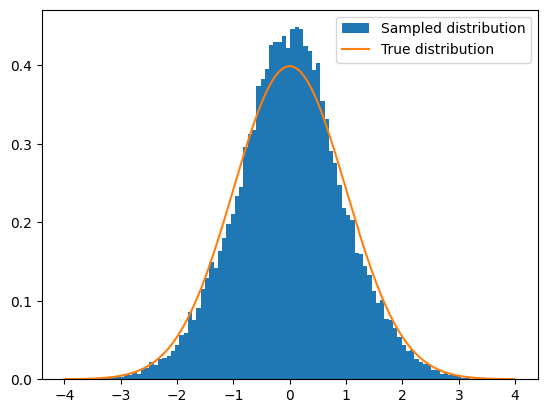

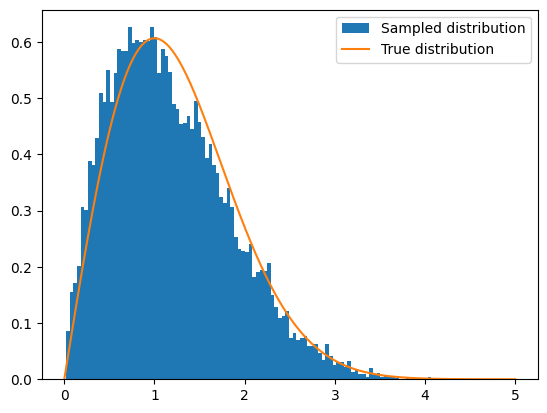

In [64]:
plt.hist(z_list_pi_1,bins=100, density=True, label="Sampled distribution")
plt.plot(t_1,z_true_sampled_1, label="True distribution")
plt.legend()
plt.show()

plt.hist(z_list_pi_2, bins=100, density=True, label="Sampled distribution")
plt.plot(t_2,z_true_sampled_2, label="True distribution")
plt.legend()
plt.show()